In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
import pandas

2023-12-05 01:11:36.579599: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-05 01:11:36.611984: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
train_file = "../train.tsv"
test_file = "../test.tsv"

train_data = pandas.read_csv(train_file, delimiter='\t').to_numpy()
train_data2 = np.empty((train_data.shape[0], train_data.shape[1]-2))
train_data2[:, 0:] = train_data[:, 2:]
train_data2[:,0:1] = train_data2[:, 0:1] * 2.7 / 4   #季節を正規化
train_data2[:,2:3] = train_data2[:, 2:3] * 1.8 / 12 #月を正規化
train_data2[:,3:4] = train_data2[:, 3:4] * 62.3 / 23 #時間を正規化
train_data2[:,5:6] = train_data2[:, 5:6] * 1.4 / 6.0   #曜日を正規化
train_data2[:,7:8] = train_data2[:, 7:8] * 2.2 / 4.0   #天気を正規化
train_data2[:,8:9] = train_data2[:, 8:9] * 9.5
train_data2[:,9:10] = train_data2[:, 9:10] * 8.9
train_data2[:,10:11] = train_data2[:, 10:11] * 3.4
train_data2[:,11:12] = train_data2[:, 11:12] * 1.5

train_data2 = train_data2#.astype(np.float32)
rnd = np.random.default_rng()
rnd.shuffle(train_data2,axis=0)

test_data = pandas.read_csv(test_file, delimiter='\t').to_numpy()
test_data2 = np.empty((test_data.shape[0], test_data.shape[1]-2))
test_data2[:, 0:] = test_data[:, 2:]
test_data2[:,0:1] = test_data2[:, 0:1] * 2.7 / 4   #季節を正規化
test_data2[:,2:3] = test_data2[:, 2:3] * 1.8 / 12 #月を正規化
test_data2[:,3:4] = test_data2[:, 3:4] * 62.3 / 23 #時間を正規化
test_data2[:,5:6] = test_data2[:, 5:6] * 1.4 / 6.0   #曜日を正規化
test_data2[:,7:8] = test_data2[:, 7:8] * 2.2 / 4.0   #天気を正規化
test_data2[:,8:9] = test_data2[:, 8:9] * 9.5
test_data2[:,9:10] = test_data2[:, 9:10] * 8.9
test_data2[:,10:11] = test_data2[:, 10:11] * 3.4
test_data2[:,11:12] = test_data2[:, 11:12] * 1.5
test_data2 = test_data2#.astype(np.float32)

display(train_data2)
display(test_data2)

x = train_data2[:, 12:]
x = x.reshape(x.shape[0], 1)
#print(x)
y = train_data2[:, :12]
y = y.reshape(y.shape[0], y.shape[1], 1)
#print(y)
test_y = test_data2.reshape(test_data2.shape[0], test_data2.shape[1], 1)
z = test_data2[:, :12]
z = z.reshape(z.shape[0], z.shape[1], 1)

array([[2.0250e+00, 0.0000e+00, 1.0500e+00, ..., 2.1080e+00, 2.0145e-01,
        3.2600e+02],
       [1.3500e+00, 0.0000e+00, 7.5000e-01, ..., 2.6520e+00, 2.0145e-01,
        1.4100e+02],
       [2.7000e+00, 0.0000e+00, 1.5000e+00, ..., 1.1900e+00, 4.2540e-01,
        3.7700e+02],
       ...,
       [6.7500e-01, 0.0000e+00, 3.0000e-01, ..., 3.4000e+00, 4.4775e-01,
        7.9000e+01],
       [1.3500e+00, 0.0000e+00, 7.5000e-01, ..., 2.8220e+00, 2.4630e-01,
        1.4600e+02],
       [1.3500e+00, 0.0000e+00, 6.0000e-01, ..., 1.2920e+00, 2.4630e-01,
        1.9900e+02]])

array([[0.675  , 1.     , 0.15   , ..., 3.37132, 2.244  , 0.     ],
       [0.675  , 1.     , 0.15   , ..., 3.10165, 2.244  , 0.20145],
       [0.675  , 1.     , 0.15   , ..., 3.10165, 2.584  , 0.     ],
       ...,
       [0.675  , 1.     , 1.8    , ..., 2.29264, 2.04   , 0.2463 ],
       [0.675  , 1.     , 1.8    , ..., 2.42703, 1.904  , 0.20145],
       [0.675  , 1.     , 1.8    , ..., 2.42703, 2.21   , 0.20145]])

In [3]:
length_of_sequence = y.shape[1]
#print(length_of_sequence)
in_out_neurons = 1 #入出力ノード数
n_hidden = 1024  #隠れ層 -> 数が多い程，学習モデルの複雑さが増加 #増やした

model = Sequential()
model.add(LSTM(n_hidden, input_shape=(length_of_sequence, in_out_neurons), return_sequences=False))
model.add(Dense(in_out_neurons))
model.add(Activation("linear"))
optimizer = Adam(learning_rate=0.001)
model.compile(loss="mean_squared_error", optimizer=optimizer, metrics=["accuracy"])

2023-12-05 01:11:38.779991: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-05 01:11:38.801510: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-05 01:11:38.801549: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-05 01:11:38.804498: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-05 01:11:38.804534: I tensorflow/compile

In [4]:
y.shape

(8645, 12, 1)

In [5]:
ES = EarlyStopping(mode='auto', patience=32)
model.fit(y, x,
          batch_size=32, #デフォは32
          epochs=512, #512epochで学習
          validation_split=0.2, #学習データの5%をvalidationに用いる
          callbacks=[ES]
          )

Epoch 1/512


2023-12-05 01:11:42.528860: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8905
2023-12-05 01:11:43.332965: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-12-05 01:11:43.356551: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f3b8816a090 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-05 01:11:43.356662: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Laptop GPU, Compute Capability 8.9
2023-12-05 01:11:43.362562: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-12-05 01:11:43.459261: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifeti

217/217 [==============================] - 5s 7ms/step - loss: 35692.0469 - accuracy: 0.0120 - val_loss: 36862.2227 - val_accuracy: 0.0104
Epoch 2/512
217/217 [==============================] - 1s 6ms/step - loss: 33104.1719 - accuracy: 0.0132 - val_loss: 34878.1875 - val_accuracy: 0.0104
Epoch 3/512
217/217 [==============================] - 2s 8ms/step - loss: 31349.8027 - accuracy: 0.0132 - val_loss: 33156.8477 - val_accuracy: 0.0104
Epoch 4/512
217/217 [==============================] - 1s 7ms/step - loss: 29794.1289 - accuracy: 0.0132 - val_loss: 31603.1855 - val_accuracy: 0.0104
Epoch 5/512
217/217 [==============================] - 1s 6ms/step - loss: 28390.6914 - accuracy: 0.0132 - val_loss: 30194.4180 - val_accuracy: 0.0104
Epoch 6/512
217/217 [==============================] - 1s 6ms/step - loss: 27118.5332 - accuracy: 0.0132 - val_loss: 28906.7090 - val_accuracy: 0.0104
Epoch 7/512
217/217 [==============================] - 1s 6ms/step - loss: 25966.0898 - accuracy: 0.0132 -

KeyboardInterrupt: 

In [6]:
predicted = model.predict(y,batch_size=32)
model.evaluate(y,x,batch_size=32)

271/271 [==============================] - 1s 3ms/step - loss: 1534.1836 - accuracy: 0.0111


[1534.18359375, 0.011104685254395008]

In [7]:
r2 = 1 -  np.sum((predicted - x)**2) / np.sum((x - np.mean(x))**2)
print(r2)

0.9142904331663307


In [8]:
predicted

array([[227.64644],
       [160.99013],
       [400.7686 ],
       ...,
       [ 91.0819 ],
       [112.60775],
       [168.05696]], dtype=float32)

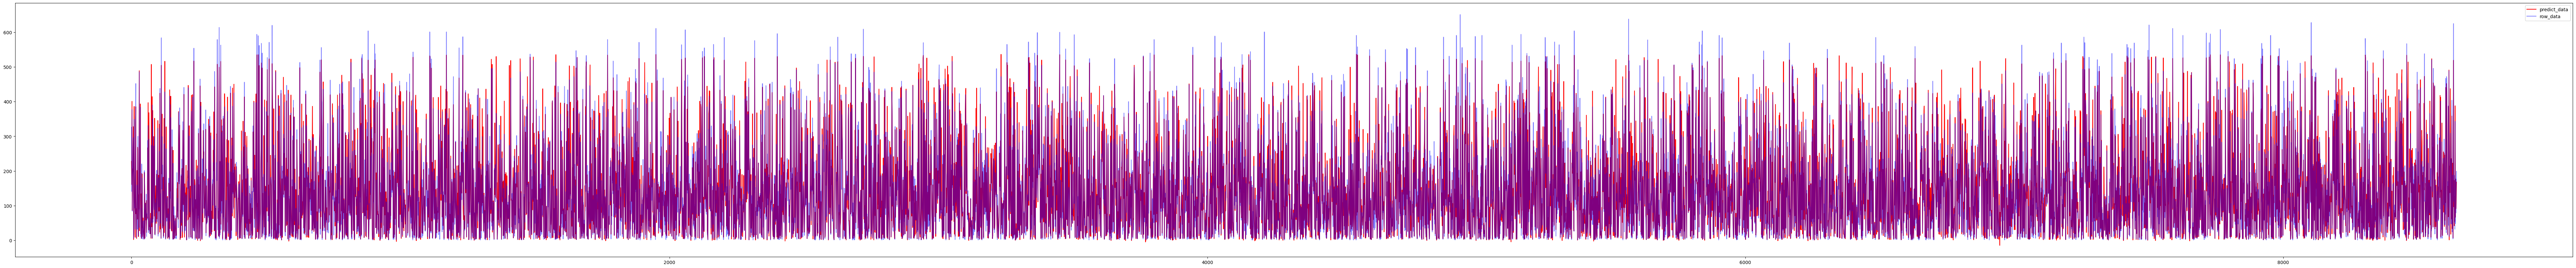

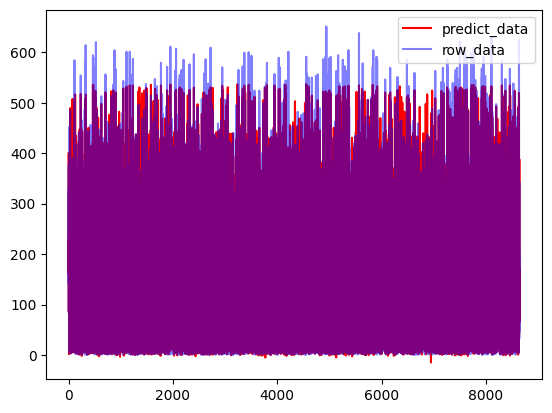

In [9]:
plt.figure(figsize=(100,10))
plt.plot(range(0,len(predicted)),predicted, color="r", label="predict_data")
plt.plot(range(0, len(x)), x, color="b", label="row_data", alpha=0.5)
plt.legend()
plt.show()

plt.figure()
plt.plot(range(0,len(predicted)),predicted, color="r", label="predict_data")
plt.plot(range(0, len(x)), x, color="b", label="row_data", alpha=0.5)
plt.legend()
plt.show()

1092/1092 [==============================] - 2s 2ms/step
[[39]
 [31]
 [ 5]
 ...
 [52]
 [54]
 [50]]
39
31
5
0
2
6
4
31
31
64
125
200
269
275
287
308
239
229
148
67
82
81
67
60
41
14
3
2
9
12
31
41
105
111
111
157
154
136
135
144
132
96
45
23
27
26
25
12
3
3
1
5
28
73
226
351
134
69
87
83
74
71
78
145
254
170
113
78
62
40
25
8
2
6
7
7
17
95
272
373
173
105
113
103
78
73
74
126
206
179
124
101
89
73
62
14
4
4
4
8
27
63
199
303
150
89
151
125
111
103
123
223
260
221
164
130
92
77
60
14
3
3
2
7
21
61
211
278
147
115
161
171
168
182
222
341
396
311
194
149
123
98
95
40
27
11
7
2
10
15
39
35
71
93
162
290
331
369
417
344
277
260
178
151
130
120
106
53
33
11
3
5
7
11
24
35
83
194
247
272
277
269
267
251
174
120
84
61
42
37
24
11
6
4
4
3
24
61
148
271
139
77
77
73
69
57
59
66
152
109
91
69
57
44
39
11
2
1
3
36
47
165
302
103
53
136
127
116
114
116
212
360
253
193
128
89
59
40
17
2
2
3
4
28
61
170
291
117
65
68
68
68
61
70
92
142
123
89
75
65
53
45
21
5
3
1
12
19
59
210
301
155
102
88
83
116
110

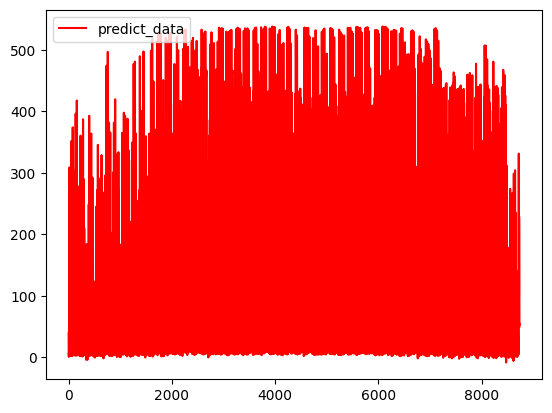

In [10]:
predictedz = model.predict(z,batch_size=8)
zzzzzz = predictedz.astype("int32")
print(zzzzzz)
shit = 0
for i in range(0,8733):
    print(zzzzzz[i,0])
    if zzzzzz[i,0] < 0:
        shit += 1
print(np.shape(zzzzzz))
print(shit)

plt.figure()
plt.plot(range(0,len(zzzzzz)),predictedz, color="r", label="predict_data")
plt.legend()
plt.show()